# Pre-cQTL analysis control samples data wrangling

__Author:__ Bryan Quach  
__Date:__ June 8, 2017

## Objective: Create phenotype and design matrices for cQTL analysis

The cQTL software requires as input a [design matrix](https://en.wikipedia.org/wiki/Design_matrix) and a phenotype matrix. This document outlines the steps we take in generating the matrices for downstream tissue-specific cQTL analyses in control samples. This had been done previously, but in this notebook we will be applying a more stringent filtering.

### Estimated Analysis Time: <1 days*

**This estimate assumes that the analysis will be done as shown below with unlimited computing resources to distribute processing tasks, an internet connection with high speed data transfer rates, and all necessary software already installed. Limitations in any of the aforementioned can significantly increase analysis time.*

## Software

* [DESeq2](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)
* [BEDTools](http://bedtools.readthedocs.io)

## Analysis Outline

* Creating tissue-specific phenotype matrices
* Creating tissue-specific covariate matrices

## Phenotype matrix construction

The phenotype we will use is chromatin accessibility values in liver, lung, and kidney tissue. We start by creating per-tissue set of open chromatin regions derived from the union of all F-seq peak calls per control sample. With these we calculate read coverage and make count matrices that are then normalized by library size using DESeq2. As discovered previously, `CC018_Control_LIVER_ATAC_81` and `CC051_Control_KIDNEY_ATAC_26` appear to be problematic samples, so they are excluded from the analysis.

To speed up the coverage calculations, we distribute the tasks on UNC's Longleaf cluster. The alignment files we use are sorted and shifted BED files output from the Furey Lab ATAC-seq data processing pipeline.

In [ ]:
#Do this on Longleaf
cd /proj/fureylab/data/ATAC/mouse/CC
mkdir coverage_calc

#Load modules
module load bedtools

#Perform file clean-up as a safety pre-caution
rm CC0*/*/*top50k.npf
rm CC0*/*/*300bpNS.bed
rm CC0*/*/*csaw*bam.bai
rm CC0*/*/*csaw*bam

#For each control sample npf file, retrieve the top 50k open chromatin peaks:
for file in CC0*/*Control*/*npf
do
    echo $file
    sbatch -n 1 --mem=1G --time=1:00:00 --wrap="sort -rnk 7 $file | head -n 50000 > coverage_calc/$(basename ${file/.npf/.top50k.npf})"
done

#Check that each new npf file has 50k peaks
for file in CC0*/*Control*/*top50k.npf; do wc -l coverage_calc/$(basename $file); done

#Create tissue specific peak union sets
cat coverage_calc/*KIDNEY*top50k.npf > coverage_calc/top50k_cat_kidney.npf
cat coverage_calc/*LUNG*top50k.npf > coverage_calc/top50k_cat_lung.npf
cat coverage_calc/*LIVER*top50k.npf > coverage_calc/top50k_cat_liver.npf
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_kidney.npf > coverage_calc/top50_cat_kidney_sorted.bed'
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_lung.npf > coverage_calc/top50_cat_lung_sorted.bed'
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_liver.npf > coverage_calc/top50_cat_liver_sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_kidney_sorted.bed -c 1 -o count > coverage_calc/top50k_kidney_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_lung_sorted.bed -c 1 -o count > coverage_calc/top50k_lung_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_liver_sorted.bed -c 1 -o count > coverage_calc/top50k_liver_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_kidney_union.bed > coverage_calc/top50k_kidney_union.sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_liver_union.bed > coverage_calc/top50k_liver_union.sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_lung_union.bed > coverage_calc/top50k_lung_union.sorted.bed'

#Create windows
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_kidney.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_kidney_union.sorted.bed coverage_calc/300bp_windows_kidney.bed 8'
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_liver.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_liver_union.sorted.bed coverage_calc/300bp_windows_liver.bed 8'
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_lung.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_lung_union.sorted.bed coverage_calc/300bp_windows_lung.bed 8'
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_kidney.bed > coverage_calc/300bp_windows_kidney.sorted.bed"
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_liver.bed > coverage_calc/300bp_windows_liver.sorted.bed"
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_lung.bed > coverage_calc/300bp_windows_lung.sorted.bed"

#Calculate coverage in windows for each shifted sorted bed file
#BEDTools version must be at least 2.24.0
for file in CC*/*Control_KIDNEY*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_kidney.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_kidney.bed})"
done

for file in CC*/*Control_LIVER*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_liver.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_liver.bed})"
done

for file in CC*/*Control_LUNG*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_lung.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_lung.bed})"
done

#Get coverage data column and merge
kidney_cov_files=($(ls coverage_calc/ss*.coverage_300bp_kidney.bed))
liver_cov_files=($(ls coverage_calc/ss*.coverage_300bp_liver.bed))
lung_cov_files=($(ls coverage_calc/ss*.coverage_300bp_lung.bed))
for i in ${kidney_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
for i in ${liver_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
for i in ${lung_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_kidney.txt > coverage_calc/count_matrix_kidney.txt"
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_liver.txt > coverage_calc/count_matrix_liver.txt"
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_lung.txt > coverage_calc/count_matrix_lung.txt"

#Combine all count matrix data
awk '{OFS="."} {print $1,$2,$3}' ${kidney_cov_files[0]} > coverage_calc/count_matrix_kidney_rownames.txt
awk '{OFS="."} {print $1,$2,$3}' ${liver_cov_files[0]} > coverage_calc/count_matrix_liver_rownames.txt
awk '{OFS="."} {print $1,$2,$3}' ${lung_cov_files[0]} > coverage_calc/count_matrix_lung_rownames.txt
ls coverage_calc/ss*.coverage_300bp_kidney.txt | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_kidney_colnames.txt
ls coverage_calc/ss*.coverage_300bp_liver.txt | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_liver_colnames.txt
ls coverage_calc/ss*.coverage_300bp_lung.txt | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_lung_colnames.txt
cat <(echo "region") coverage_calc/count_matrix_kidney_colnames.txt > coverage_calc/count_matrix_kidney_colnames.txt.tmp
cat <(echo "region") coverage_calc/count_matrix_liver_colnames.txt > coverage_calc/count_matrix_liver_colnames.txt.tmp
cat <(echo "region") coverage_calc/count_matrix_lung_colnames.txt > coverage_calc/count_matrix_lung_colnames.txt.tmp
mv coverage_calc/count_matrix_kidney_colnames.txt.tmp coverage_calc/count_matrix_kidney_colnames.txt
mv coverage_calc/count_matrix_liver_colnames.txt.tmp coverage_calc/count_matrix_liver_colnames.txt
mv coverage_calc/count_matrix_lung_colnames.txt.tmp coverage_calc/count_matrix_lung_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_kidney_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_liver_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_lung_colnames.txt
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_kidney_colnames.txt #remove tag at end of line
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_liver_colnames.txt #remove tag at end of line
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_lung_colnames.txt #remove tag at end of line
cat coverage_calc/count_matrix_kidney_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_kidney_rownames.txt coverage_calc/count_matrix_kidney.txt) > coverage_calc/atac_regions_control_count_matrix_kidney.txt
cat coverage_calc/count_matrix_liver_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_liver_rownames.txt coverage_calc/count_matrix_liver.txt) > coverage_calc/atac_regions_control_count_matrix_liver.txt
cat coverage_calc/count_matrix_lung_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_lung_rownames.txt coverage_calc/count_matrix_lung.txt) > coverage_calc/atac_regions_control_count_matrix_lung.txt


In [1]:
#Execute locally
#Retrieve data from server
scp longleaf.unc.edu:/proj/fureylab/data/ATAC/mouse/CC/coverage_calc/atac_regions_control_count_matrix*txt data/
ssh longleaf.unc.edu "rm -r /proj/fureylab/data/ATAC/mouse/CC/coverage_calc/"

|-----------------------------------------------------------------|
|     The University of North Carolina at Chapel Hill             |
|     ***********************************************             |
|     Unauthorized access to this system is prohibited.           |
|                                                                 |
| This is a University system intended for University purposes    |
| only. The University reserves the right to monitor the use of   |
| this system as required to ensure its stability, availability,  |
| and security.                                                   |
|                                                                 |
| Please report any problems to "help@unc.edu", or 962-HELP,      |
| or go to http://help.unc.edu/help/research-computing-contact-us/|
| to submit a help request.                                       |
|-----------------------------------------------------------------|
atac_regions_count_matrix_kidney.txt          10

## Matrix normalization and filtering

We apply median ratio normalization using DESeq2. This decision is based off of discussions with Dr. Michael Love about making samples comparable to each other.

In [1]:
library(DESeq2)

#Get count data
cts.lung <- as.matrix(read.delim("data/atac_regions_control_count_matrix_lung.txt", header=T, row.names=1))
cts.liver <- as.matrix(read.delim("data/atac_regions_control_count_matrix_liver.txt", header=T, row.names=1))
cts.kidney <- as.matrix(read.delim("data/atac_regions_control_count_matrix_kidney.txt", header=T, row.names=1))

#Filter out chrY and chrM
keep.region <- sapply(strsplit(rownames(cts.lung), split=".", fixed=T), function(x){!(x[1] %in% c("chrY","chrM"))})
cts.lung <- cts.lung[keep.region,]
keep.region <- sapply(strsplit(rownames(cts.liver), split=".", fixed=T), function(x){!(x[1] %in% c("chrY","chrM"))})
cts.liver <- cts.liver[keep.region,]
keep.region <- sapply(strsplit(rownames(cts.kidney), split=".", fixed=T), function(x){!(x[1] %in% c("chrY","chrM"))})
cts.kidney <- cts.kidney[keep.region,]

#Normalize by library size
size.factors.lung <- estimateSizeFactorsForMatrix(cts.lung)
size.factors.liver <- estimateSizeFactorsForMatrix(cts.liver)
size.factors.kidney <- estimateSizeFactorsForMatrix(cts.kidney)
cts.lung.normalized <- sweep(cts.lung, 2, size.factors.lung, "/")
cts.liver.normalized <- sweep(cts.liver, 2, size.factors.liver, "/")
cts.kidney.normalized <- sweep(cts.kidney, 2, size.factors.kidney, "/")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [ ]:
#Visualize before and after normalization
options(repr.plot.width=8, repr.plot.height=8)

#Lung
log.cts.lung <- log10(cts.lung)
log.cts.lung.normalized <- log10(cts.lung.normalized)
is.na(log.cts.lung) <- sapply(log.cts.lung, is.infinite)
is.na(log.cts.lung.normalized) <- sapply(log.cts.lung.normalized, is.infinite)
par(mfrow=c(2,1))
boxplot(log.cts.lung, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(counts)", xlab="Samples", main="Lung")
boxplot(log.cts.lung.normalized, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized counts)", xlab="Samples")

In [ ]:
#Liver
log.cts.lung <- log10(cts.lung)
log.cts.liver.normalized <- log10(cts.liver.normalized)
is.na(log.cts.lung) <- sapply(log.cts.lung, is.infinite)
is.na(log.cts.liver.normalized) <- sapply(log.cts.liver.normalized, is.infinite)
par(mfrow=c(2,1))
boxplot(log.cts.lung, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(counts)", xlab="Samples", main="Liver")
boxplot(log.cts.liver.normalized, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized counts)", xlab="Samples")

In [ ]:
#Kidney
log.cts.kidney <- log10(cts.kidney)
log.cts.kidney.normalized <- log10(cts.kidney.normalized)
is.na(log.cts.kidney) <- sapply(log.cts.kidney, is.infinite)
is.na(log.cts.kidney.normalized) <- sapply(log.cts.kidney.normalized, is.infinite)
par(mfrow=c(2,1))
boxplot(log.cts.kidney, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(counts)", xlab="Samples", main="Kidney")
boxplot(log.cts.kidney.normalized, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized counts)", xlab="Samples")

Based on the boxplots above, the normalizations appear to have appropriately scaled the count values across samples to make them more comparable.

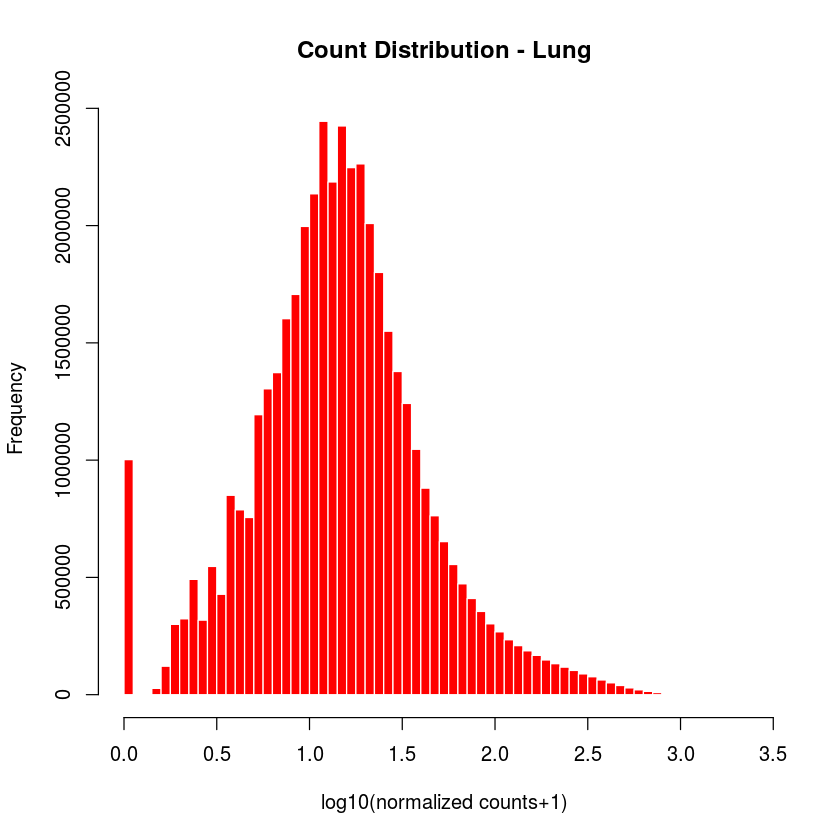

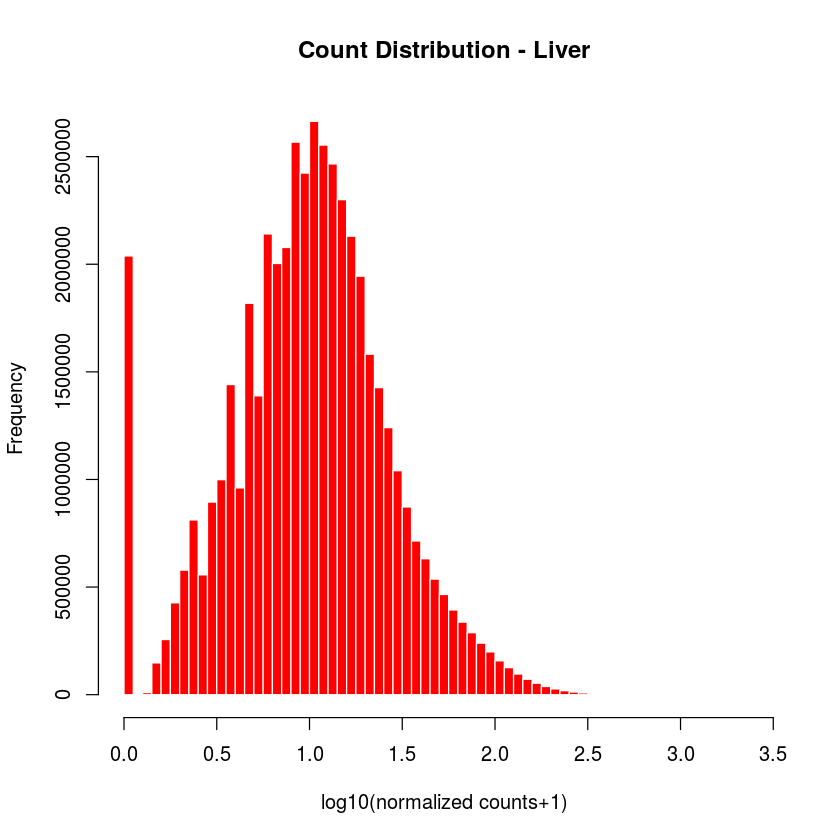

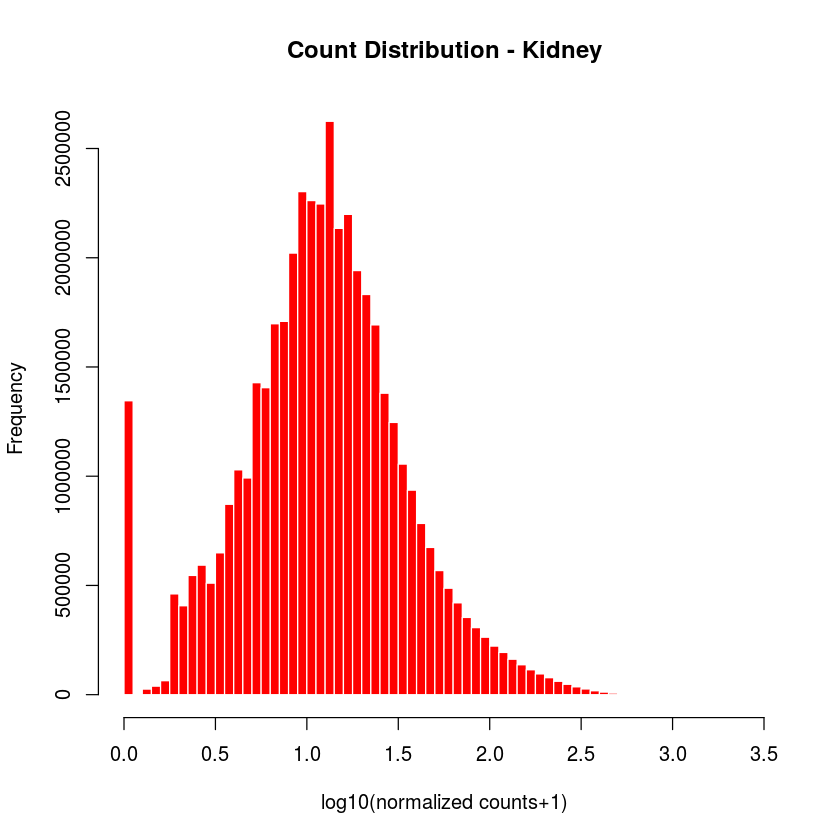

In [2]:
#Visualize normalized count distribution
hist(log10(cts.lung.normalized+1), breaks=100, col="red", border="white",
     xlab="log10(normalized counts+1)", main="Count Distribution - Lung")
hist(log10(cts.liver.normalized+1), breaks=100, col="red", border="white",
     xlab="log10(normalized counts+1)", main="Count Distribution - Liver")
hist(log10(cts.kidney.normalized+1), breaks=100, col="red", border="white",
     xlab="log10(normalized counts+1)", main="Count Distribution - Kidney")

To reduce the number of regions we will be including in the cQTL analysis, we use a filtering criteria similar to that used by [*Degner et al.*](https://www.nature.com/nature/journal/v482/n7385/extref/nature10808-s1.pdf) Any regions called as hypersensitive in less than 20% of samples are removed. Hypersensitivity is defined by the the 80th percentile of normalized counts of all regions across all samples. Because it is estimated that 2-3% of the genome is hypersensitive at a given point, 20% is considered a liberal threshold. Following this filtering, the top 5% of sites based on total normalized counts are retained.

In [3]:
## Filter out low coverage regions
kidney.cutoff <- quantile(cts.kidney.normalized, probs=0.8)
liver.cutoff <- quantile(cts.liver.normalized, probs=0.8)
lung.cutoff <- quantile(cts.lung.normalized, probs=0.8)
kidney.keep <- apply(cts.kidney.normalized, 1, function(y){length(which(y>kidney.cutoff))}) >= 0.20*ncol(cts.kidney.normalized)
liver.keep <- apply(cts.liver.normalized, 1, function(y){length(which(y>liver.cutoff))}) >= 0.20*ncol(cts.liver.normalized)
lung.keep <- apply(cts.lung.normalized, 1, function(y){length(which(y>lung.cutoff))}) >= 0.20*ncol(cts.lung.normalized)
cts.kidney.normalized <- t(cts.kidney.normalized[kidney.keep,])
cts.liver.normalized <- t(cts.liver.normalized[liver.keep,])
cts.lung.normalized <- t(cts.lung.normalized[lung.keep,])
# Calculate total hypersensitivity per window
kidney.colsums <- colSums(cts.kidney.normalized)
liver.colsums <- colSums(cts.liver.normalized)
lung.colsums <- colSums(cts.lung.normalized)
# Filter to top 5% of sites ranked by hypersensitivity
cts.kidney.normalized <- cts.kidney.normalized[,which(kidney.colsums>=quantile(kidney.colsums, probs=0.95))]
cts.liver.normalized <- cts.liver.normalized[,which(liver.colsums>=quantile(liver.colsums, probs=0.95))]
cts.lung.normalized <- cts.lung.normalized[,which(lung.colsums>=quantile(lung.colsums, probs=0.95))]

#Rename rows
lung.new.names <- as.character(sapply(strsplit(x=rownames(cts.lung.normalized), split="ss", fixed=T), function(x){x[2]}))
liver.new.names <- as.character(sapply(strsplit(x=rownames(cts.liver.normalized), split="ss", fixed=T), function(x){x[2]}))
kidney.new.names <- as.character(sapply(strsplit(x=rownames(cts.kidney.normalized), split="ss", fixed=T), function(x){x[2]}))
rownames(cts.lung.normalized) <- lung.new.names
rownames(cts.liver.normalized) <- liver.new.names
rownames(cts.kidney.normalized) <- kidney.new.names

By this point the matrices of counts are almost in the correct form for use with the QTL analysis software. Once we have created the covariate matrices, we can convert everything into the final format.

## Covariate matrix construction

The covariate matrices that we construct contain the following information for each sample:

* Sample ID - we use CC strain ID for this
* Sequencing batch
* Haplotype dosages for every marker

Unlike the CC RNA-seq data that we processed, all the samples for ATAC-seq were sequenced at UNC's Highthroughput Sequencing Facility (HTSF), so we do not need to include sequencing center as a covariate.

In [10]:
#Get sample names and ID
sample.names <- c(rownames(cts.lung.normalized),
                  rownames(cts.liver.normalized),
                  rownames(cts.kidney.normalized))
id <- sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][5]})
strain <- sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][1]})
center <- rep(NA,length(strain)) #dummy variable for cQTL software compatibility
sample.names <- sub(pattern="Control", replacement="0ppm", x=sample.names, ignore.case=T)
sample.names <- sub(pattern="_ATAC", replacement="", x=sample.names, fixed=T)
treatment <- sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][2]})
tissue <- toupper(sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][3]}))
sample.names <- paste(tissue, treatment, id, sep="_")
sample.info <- data.frame(Sample=sample.names, Strain=strain, Center=center)

#Load batch labels and add to partial covariate matrix
batch <- read.delim("../batch_info.txt", header=F, stringsAsFactors=F)
batch.indices <- sapply(sample.info$Sample, function(x){which(batch[,1]==x)})
cov.data <- cbind(sample.info, batch[batch.indices,2])
colnames(cov.data) <- c("Sample", "Strain", "Center", "Batch")

#Load haplotype dosage matrix
dosages <- as.data.frame(readRDS("../../genotype/20170331_covariate_matrix/results/dosage_covariate_matrix_segmented.rds"), stringsAsFactors=F)
rownames(dosages) <- dosages$ID 
dosages <- dosages[,-1] #remove ID column

#Create covariate matrices for each tissue
kidney.covdata <- cov.data[grepl(pattern="KIDNEY", x=cov.data$Sample, fixed=T),][,c("Strain","Center","Batch")]
kidney.dosages <- dosages[sapply(kidney.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
kidney.covdata <- cbind(kidney.covdata, kidney.dosages)
liver.covdata <- cov.data[grepl(pattern="LIVER", x=cov.data$Sample, fixed=T),][,c("Strain","Center","Batch")]
liver.dosages <- dosages[sapply(liver.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
liver.covdata <- cbind(liver.covdata, liver.dosages)
lung.covdata <- cov.data[grepl(pattern="LUNG", x=cov.data$Sample, fixed=T),][,c("Strain","Center","Batch")]
lung.dosages <- dosages[sapply(lung.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
lung.covdata <- cbind(lung.covdata, lung.dosages)

## Sample Renaming 

In [13]:
names.lung <- rownames(cts.lung.normalized)
names.liver <- rownames(cts.liver.normalized)
names.kidney <- rownames(cts.kidney.normalized)
names.lung <- sub(pattern="Control", replacement="0ppm", x=names.lung, fixed=T)
names.liver <- sub(pattern="Control", replacement="0ppm", x=names.liver, fixed=T)
names.kidney <- sub(pattern="Control", replacement="0ppm", x=names.kidney, fixed=T)

## Matrix reformatting and saving

With the expression matrices and covariate matrices in the right structure, we rename the strain column to "ID" as required by the cQTL software, rename the rows of the expression matrices to be strain names, and save the matrices to files.

In [14]:
colnames(kidney.covdata)[1] <- "ID"
colnames(liver.covdata)[1] <- "ID"
colnames(lung.covdata)[1] <- "ID"
rownames(cts.kidney.normalized) <- sample.info[sapply(rownames(cts.kidney.normalized), function(x){which(rownames(sample.info)==x)}),][,"Strain"]
rownames(cts.liver.normalized) <- sample.info[sapply(rownames(cts.liver.normalized), function(x){which(rownames(sample.info)==x)}),][,"Strain"]
rownames(cts.lung.normalized) <- sample.info[sapply(rownames(cts.lung.normalized), function(x){which(rownames(sample.info)==x)}),][,"Strain"]

#Matrix size sanity check - each should be strain x gene/covariate
#Covariate matrices should be equal width
dim(cts.kidney.normalized)
dim(cts.liver.normalized)
dim(cts.lung.normalized)
dim(kidney.covdata)
dim(liver.covdata)
dim(lung.covdata)

#Save matrices
saveRDS(object=cts.kidney.normalized, file="results/expmat_control_kidney.rds")
saveRDS(object=cts.liver.normalized, file="results/expmat_control_liver.rds")
saveRDS(object=cts.lung.normalized, file="results/expmat_control_lung.rds")
saveRDS(object=kidney.covdata, file="results/covdata_control_kidney.rds")
saveRDS(object=liver.covdata, file="results/covdata_control_liver.rds")
saveRDS(object=lung.covdata, file="results/covdata_control_lung.rds")

[1]    48 12435

[1]    48 13653

[1]    49 11870

[1]    48 40131

[1]    48 40131

[1]    49 40131

# Pre-cQTL analysis 625ppm samples data wrangling

__Author:__ Bryan Quach  
__Date:__ June 8, 2017

## Objective: Create phenotype and design matrices for cQTL analysis

The cQTL software requires as input a [design matrix](https://en.wikipedia.org/wiki/Design_matrix) and a phenotype matrix. This document outlines the steps we take in generating the matrices for downstream tissue-specific cQTL analyses in control samples. This had been done previously, but in this notebook we will be applying a more stringent filtering.

### Estimated Analysis Time: <1 days*

**This estimate assumes that the analysis will be done as shown below with unlimited computing resources to distribute processing tasks, an internet connection with high speed data transfer rates, and all necessary software already installed. Limitations in any of the aforementioned can significantly increase analysis time.*

## Software

* [DESeq2](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)
* [BEDTools](http://bedtools.readthedocs.io)

## Analysis Outline

* Creating tissue-specific phenotype matrices
* Creating tissue-specific covariate matrices

## Phenotype matrix construction

The phenotype we will use is chromatin accessibility values in liver, lung, and kidney tissue. We start by creating per-tissue set of open chromatin regions derived from the union of all F-seq peak calls per sample. With these we calculate read coverage and make count matrices that are then normalized by library size using DESeq2.

To speed up the coverage calculations, we distribute the tasks on UNC's Longleaf cluster. The alignment files we use are sorted and shifted BED files output from the Furey Lab ATAC-seq data processing pipeline.

In [ ]:
#Do this on Longleaf
cd /proj/fureylab/data/ATAC/mouse/CC
mkdir coverage_calc

#Load modules
module load bedtools

#Perform file clean-up as a safety pre-caution
rm CC0*/*/*top50k.npf
rm CC0*/*/*300bpNS.bed
rm CC0*/*/*csaw*bam.bai
rm CC0*/*/*csaw*bam

#For each 625ppm sample npf file, retrieve the top 50k open chromatin peaks:
for file in CC0*/*BD625*/*npf
do
    echo $file
    sbatch -n 1 --mem=1G --time=1:00:00 --wrap="sort -rnk 7 $file | head -n 50000 > coverage_calc/$(basename ${file/.npf/.top50k.npf})"
done

#Check that each new npf file has 50k peaks
for file in CC0*/*BD625*/*top50k.npf; do wc -l coverage_calc/$(basename $file); done

#Create tissue specific peak union sets
cat coverage_calc/*KIDNEY*top50k.npf > coverage_calc/top50k_cat_kidney.npf
cat coverage_calc/*LUNG*top50k.npf > coverage_calc/top50k_cat_lung.npf
cat coverage_calc/*LIVER*top50k.npf > coverage_calc/top50k_cat_liver.npf
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_kidney.npf > coverage_calc/top50_cat_kidney_sorted.bed'
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_lung.npf > coverage_calc/top50_cat_lung_sorted.bed'
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_liver.npf > coverage_calc/top50_cat_liver_sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_kidney_sorted.bed -c 1 -o count > coverage_calc/top50k_kidney_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_lung_sorted.bed -c 1 -o count > coverage_calc/top50k_lung_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_liver_sorted.bed -c 1 -o count > coverage_calc/top50k_liver_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_kidney_union.bed > coverage_calc/top50k_kidney_union.sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_liver_union.bed > coverage_calc/top50k_liver_union.sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_lung_union.bed > coverage_calc/top50k_lung_union.sorted.bed'

#Create windows
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_kidney.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_kidney_union.sorted.bed coverage_calc/300bp_windows_kidney.bed 8'
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_liver.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_liver_union.sorted.bed coverage_calc/300bp_windows_liver.bed 8'
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_lung.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_lung_union.sorted.bed coverage_calc/300bp_windows_lung.bed 8'
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_kidney.bed > coverage_calc/300bp_windows_kidney.sorted.bed"
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_liver.bed > coverage_calc/300bp_windows_liver.sorted.bed"
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_lung.bed > coverage_calc/300bp_windows_lung.sorted.bed"

#Calculate coverage in windows for each shifted sorted bed file
#BEDTools version must be at least 2.24.0
for file in CC*/*BD625_KIDNEY*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_kidney.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_kidney.bed})"
done

for file in CC*/*BD625_LIVER*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_liver.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_liver.bed})"
done

for file in CC*/*BD625_LUNG*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_lung.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_lung.bed})"
done

#Get coverage data column and merge
kidney_cov_files=($(ls coverage_calc/ss*.coverage_300bp_kidney.bed))
liver_cov_files=($(ls coverage_calc/ss*.coverage_300bp_liver.bed))
lung_cov_files=($(ls coverage_calc/ss*.coverage_300bp_lung.bed))
for i in ${kidney_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
for i in ${liver_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
for i in ${lung_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_kidney.txt > coverage_calc/count_matrix_kidney.txt"
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_liver.txt > coverage_calc/count_matrix_liver.txt"
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_lung.txt > coverage_calc/count_matrix_lung.txt"

#Combine all count matrix data
awk '{OFS="."} {print $1,$2,$3}' ${kidney_cov_files[0]} > coverage_calc/count_matrix_kidney_rownames.txt
awk '{OFS="."} {print $1,$2,$3}' ${liver_cov_files[0]} > coverage_calc/count_matrix_liver_rownames.txt
awk '{OFS="."} {print $1,$2,$3}' ${lung_cov_files[0]} > coverage_calc/count_matrix_lung_rownames.txt
ls coverage_calc/ss*.coverage_300bp_kidney.txt | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_kidney_colnames.txt
ls coverage_calc/ss*.coverage_300bp_liver.txt | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_liver_colnames.txt
ls coverage_calc/ss*.coverage_300bp_lung.txt | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_lung_colnames.txt
cat <(echo "region") coverage_calc/count_matrix_kidney_colnames.txt > coverage_calc/count_matrix_kidney_colnames.txt.tmp
cat <(echo "region") coverage_calc/count_matrix_liver_colnames.txt > coverage_calc/count_matrix_liver_colnames.txt.tmp
cat <(echo "region") coverage_calc/count_matrix_lung_colnames.txt > coverage_calc/count_matrix_lung_colnames.txt.tmp
mv coverage_calc/count_matrix_kidney_colnames.txt.tmp coverage_calc/count_matrix_kidney_colnames.txt
mv coverage_calc/count_matrix_liver_colnames.txt.tmp coverage_calc/count_matrix_liver_colnames.txt
mv coverage_calc/count_matrix_lung_colnames.txt.tmp coverage_calc/count_matrix_lung_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_kidney_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_liver_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_lung_colnames.txt
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_kidney_colnames.txt #remove tag at end of line
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_liver_colnames.txt #remove tag at end of line
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_lung_colnames.txt #remove tag at end of line
cat coverage_calc/count_matrix_kidney_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_kidney_rownames.txt coverage_calc/count_matrix_kidney.txt) > coverage_calc/atac_regions_625ppm_count_matrix_kidney.txt
cat coverage_calc/count_matrix_liver_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_liver_rownames.txt coverage_calc/count_matrix_liver.txt) > coverage_calc/atac_regions_625ppm_count_matrix_liver.txt
cat coverage_calc/count_matrix_lung_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_lung_rownames.txt coverage_calc/count_matrix_lung.txt) > coverage_calc/atac_regions_625ppm_count_matrix_lung.txt


In [1]:
#Execute locally
#Retrieve data from server
scp longleaf.unc.edu:/proj/fureylab/data/ATAC/mouse/CC/coverage_calc/atac_regions_625ppm_count_matrix*txt data/
ssh longleaf.unc.edu "rm -r /proj/fureylab/data/ATAC/mouse/CC/coverage_calc/"

|-----------------------------------------------------------------|
|     The University of North Carolina at Chapel Hill             |
|     ***********************************************             |
|     Unauthorized access to this system is prohibited.           |
|                                                                 |
| This is a University system intended for University purposes    |
| only. The University reserves the right to monitor the use of   |
| this system as required to ensure its stability, availability,  |
| and security.                                                   |
|                                                                 |
| Please report any problems to "help@unc.edu", or 962-HELP,      |
| or go to http://help.unc.edu/help/research-computing-contact-us/|
| to submit a help request.                                       |
|-----------------------------------------------------------------|
atac_regions_count_matrix_kidney.txt          10

## Matrix normalization and filtering

We apply median ratio normalization using DESeq2. This decision is based off of discussions with Dr. Michael Love about making samples comparable to each other.

In [15]:
library(DESeq2)

#Get count data
cts.lung <- as.matrix(read.delim("data/atac_regions_625ppm_count_matrix_lung.txt", header=T, row.names=1))
cts.liver <- as.matrix(read.delim("data/atac_regions_625ppm_count_matrix_liver.txt", header=T, row.names=1))
cts.kidney <- as.matrix(read.delim("data/atac_regions_625ppm_count_matrix_kidney.txt", header=T, row.names=1))

#Filter out chrY and chrM
keep.region <- sapply(strsplit(rownames(cts.lung), split=".", fixed=T), function(x){!(x[1] %in% c("chrY","chrM"))})
cts.lung <- cts.lung[keep.region,]
keep.region <- sapply(strsplit(rownames(cts.liver), split=".", fixed=T), function(x){!(x[1] %in% c("chrY","chrM"))})
cts.liver <- cts.liver[keep.region,]
keep.region <- sapply(strsplit(rownames(cts.kidney), split=".", fixed=T), function(x){!(x[1] %in% c("chrY","chrM"))})
cts.kidney <- cts.kidney[keep.region,]

#Normalize by library size
size.factors.lung <- estimateSizeFactorsForMatrix(cts.lung)
size.factors.liver <- estimateSizeFactorsForMatrix(cts.liver)
size.factors.kidney <- estimateSizeFactorsForMatrix(cts.kidney)
cts.lung.normalized <- sweep(cts.lung, 2, size.factors.lung, "/")
cts.liver.normalized <- sweep(cts.liver, 2, size.factors.liver, "/")
cts.kidney.normalized <- sweep(cts.kidney, 2, size.factors.kidney, "/")

In [ ]:
#Visualize before and after normalization
options(repr.plot.width=8, repr.plot.height=8)

#Lung
log.cts.lung <- log10(cts.lung)
log.cts.lung.normalized <- log10(cts.lung.normalized)
is.na(log.cts.lung) <- sapply(log.cts.lung, is.infinite)
is.na(log.cts.lung.normalized) <- sapply(log.cts.lung.normalized, is.infinite)
par(mfrow=c(2,1))
boxplot(log.cts.lung, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(counts)", xlab="Samples", main="Lung")
boxplot(log.cts.lung.normalized, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized counts)", xlab="Samples")

In [ ]:
#Liver
log.cts.lung <- log10(cts.lung)
log.cts.liver.normalized <- log10(cts.liver.normalized)
is.na(log.cts.lung) <- sapply(log.cts.lung, is.infinite)
is.na(log.cts.liver.normalized) <- sapply(log.cts.liver.normalized, is.infinite)
par(mfrow=c(2,1))
boxplot(log.cts.lung, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(counts)", xlab="Samples", main="Liver")
boxplot(log.cts.liver.normalized, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized counts)", xlab="Samples")

In [ ]:
#Kidney
log.cts.kidney <- log10(cts.kidney)
log.cts.kidney.normalized <- log10(cts.kidney.normalized)
is.na(log.cts.kidney) <- sapply(log.cts.kidney, is.infinite)
is.na(log.cts.kidney.normalized) <- sapply(log.cts.kidney.normalized, is.infinite)
par(mfrow=c(2,1))
boxplot(log.cts.kidney, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(counts)", xlab="Samples", main="Kidney")
boxplot(log.cts.kidney.normalized, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized counts)", xlab="Samples")

Based on the boxplots above, the normalizations appear to have appropriately scaled the count values across samples to make them more comparable.

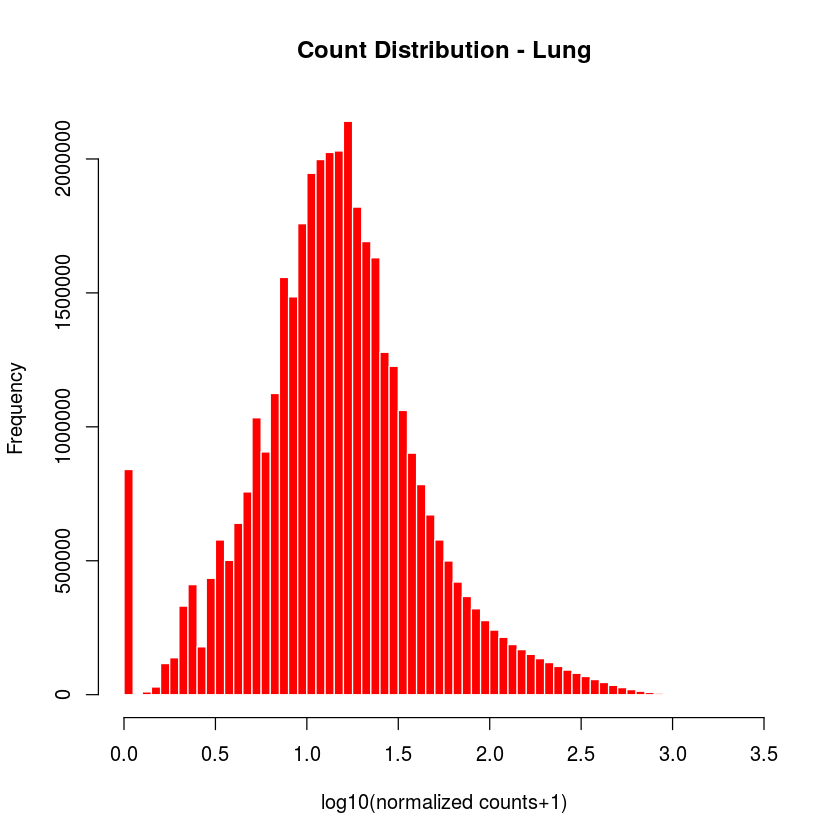

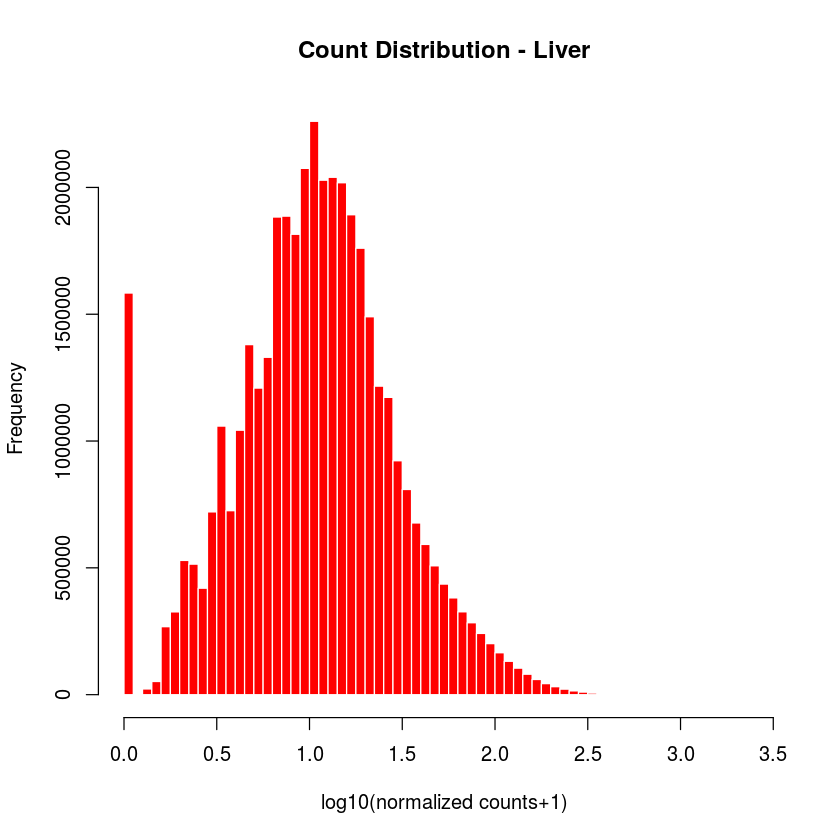

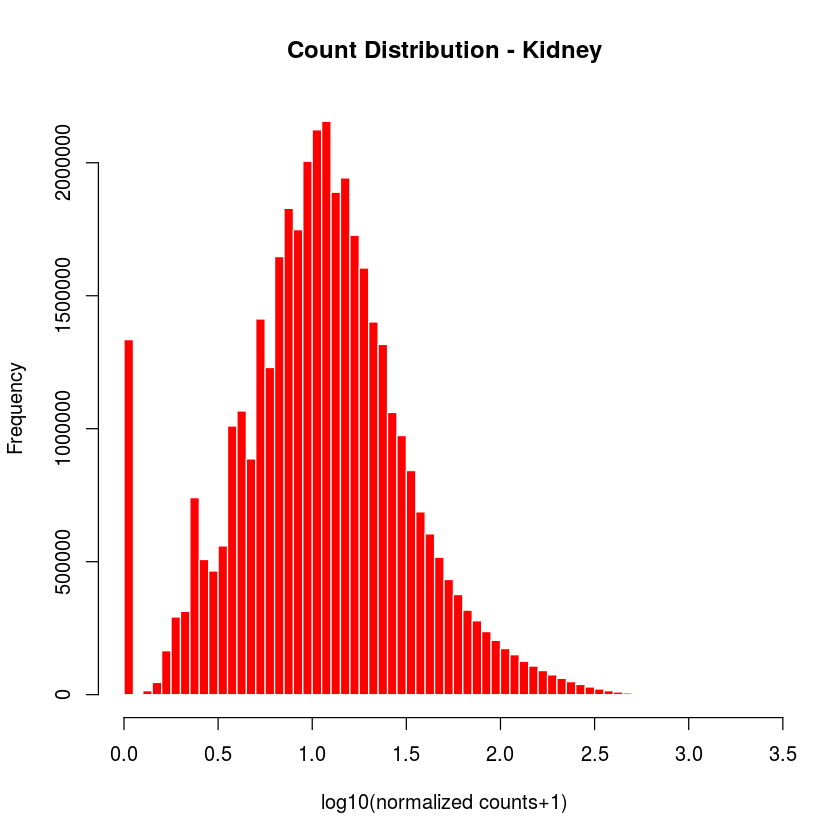

In [16]:
#Visualize normalized count distribution
hist(log10(cts.lung.normalized+1), breaks=100, col="red", border="white",
     xlab="log10(normalized counts+1)", main="Count Distribution - Lung")
hist(log10(cts.liver.normalized+1), breaks=100, col="red", border="white",
     xlab="log10(normalized counts+1)", main="Count Distribution - Liver")
hist(log10(cts.kidney.normalized+1), breaks=100, col="red", border="white",
     xlab="log10(normalized counts+1)", main="Count Distribution - Kidney")

To reduce the number of regions we will be including in the cQTL analysis, we use a filtering criteria similar to that used by [*Degner et al.*](https://www.nature.com/nature/journal/v482/n7385/extref/nature10808-s1.pdf) Any regions called as hypersensitive in less than 20% of samples are removed. Hypersensitivity is defined by the the 80th percentile of normalized counts of all regions across all samples. Because it is estimated that 2-3% of the genome is hypersensitive at a given point, 20% is considered a liberal threshold. Following this filtering, the top 5% of sites based on total normalized counts are retained.

In [17]:
## Filter out low coverage regions
kidney.cutoff <- quantile(cts.kidney.normalized, probs=0.8)
liver.cutoff <- quantile(cts.liver.normalized, probs=0.8)
lung.cutoff <- quantile(cts.lung.normalized, probs=0.8)
kidney.keep <- apply(cts.kidney.normalized, 1, function(y){length(which(y>kidney.cutoff))}) >= 0.20*ncol(cts.kidney.normalized)
liver.keep <- apply(cts.liver.normalized, 1, function(y){length(which(y>liver.cutoff))}) >= 0.20*ncol(cts.liver.normalized)
lung.keep <- apply(cts.lung.normalized, 1, function(y){length(which(y>lung.cutoff))}) >= 0.20*ncol(cts.lung.normalized)
cts.kidney.normalized <- t(cts.kidney.normalized[kidney.keep,])
cts.liver.normalized <- t(cts.liver.normalized[liver.keep,])
cts.lung.normalized <- t(cts.lung.normalized[lung.keep,])
# Calculate total hypersensitivity per window
kidney.colsums <- colSums(cts.kidney.normalized)
liver.colsums <- colSums(cts.liver.normalized)
lung.colsums <- colSums(cts.lung.normalized)
# Filter to top 5% of sites ranked by hypersensitivity
cts.kidney.normalized <- cts.kidney.normalized[,which(kidney.colsums>=quantile(kidney.colsums, probs=0.95))]
cts.liver.normalized <- cts.liver.normalized[,which(liver.colsums>=quantile(liver.colsums, probs=0.95))]
cts.lung.normalized <- cts.lung.normalized[,which(lung.colsums>=quantile(lung.colsums, probs=0.95))]

#Rename rows
lung.new.names <- as.character(sapply(strsplit(x=rownames(cts.lung.normalized), split="ss", fixed=T), function(x){x[2]}))
liver.new.names <- as.character(sapply(strsplit(x=rownames(cts.liver.normalized), split="ss", fixed=T), function(x){x[2]}))
kidney.new.names <- as.character(sapply(strsplit(x=rownames(cts.kidney.normalized), split="ss", fixed=T), function(x){x[2]}))
rownames(cts.lung.normalized) <- lung.new.names
rownames(cts.liver.normalized) <- liver.new.names
rownames(cts.kidney.normalized) <- kidney.new.names

By this point the matrices of counts are almost in the correct form for use with the QTL analysis software. Once we have created the covariate matrices, we can convert everything into the final format.

## Covariate matrix construction

The covariate matrices that we construct contain the following information for each sample:

* Sample ID - we use CC strain ID for this
* Sequencing batch
* Haplotype dosages for every marker

Unlike the CC RNA-seq data that we processed, all the samples for ATAC-seq were sequenced at UNC's Highthroughput Sequencing Facility (HTSF), so we do not need to include sequencing center as a covariate.

In [18]:
#Get sample names and ID
sample.names <- c(rownames(cts.lung.normalized),
                  rownames(cts.liver.normalized),
                  rownames(cts.kidney.normalized))
id <- sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][5]})
strain <- sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][1]})
center <- rep(NA,length(strain)) #dummy variable for cQTL software compatibility
sample.names <- sub(pattern="BD625", replacement="625ppm", x=sample.names, ignore.case=T)
sample.names <- sub(pattern="_ATAC", replacement="", x=sample.names, fixed=T)
treatment <- sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][2]})
tissue <- toupper(sapply(sample.names, function(x){strsplit(as.character(x), split="_")[[1]][3]}))
sample.names <- paste(tissue, treatment, id, sep="_")
sample.info <- data.frame(Sample=sample.names, Strain=strain, Center=center)

#Load batch labels and add to partial covariate matrix
batch <- read.delim("../batch_info.txt", header=F, stringsAsFactors=F)
batch.indices <- sapply(sample.info$Sample, function(x){which(batch[,1]==x)})
cov.data <- cbind(sample.info, batch[batch.indices,2])
colnames(cov.data) <- c("Sample", "Strain", "Center", "Batch")

#Load haplotype dosage matrix
dosages <- as.data.frame(readRDS("../../genotype/20170331_covariate_matrix/results/dosage_covariate_matrix_segmented.rds"), stringsAsFactors=F)
rownames(dosages) <- dosages$ID 
dosages <- dosages[,-1] #remove ID column

#Create covariate matrices for each tissue
kidney.covdata <- cov.data[grepl(pattern="KIDNEY", x=cov.data$Sample, fixed=T),][,c("Strain","Center","Batch")]
kidney.dosages <- dosages[sapply(kidney.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
kidney.covdata <- cbind(kidney.covdata, kidney.dosages)
liver.covdata <- cov.data[grepl(pattern="LIVER", x=cov.data$Sample, fixed=T),][,c("Strain","Center","Batch")]
liver.dosages <- dosages[sapply(liver.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
liver.covdata <- cbind(liver.covdata, liver.dosages)
lung.covdata <- cov.data[grepl(pattern="LUNG", x=cov.data$Sample, fixed=T),][,c("Strain","Center","Batch")]
lung.dosages <- dosages[sapply(lung.covdata$Strain, function(x){which(rownames(dosages)==x)}),]
lung.covdata <- cbind(lung.covdata, lung.dosages)

## Sample Renaming 

In [19]:
names.lung <- rownames(cts.lung.normalized)
names.liver <- rownames(cts.liver.normalized)
names.kidney <- rownames(cts.kidney.normalized)
names.lung <- sub(pattern="BD625", replacement="625ppm", x=names.lung, fixed=T)
names.liver <- sub(pattern="BD625", replacement="625ppm", x=names.liver, fixed=T)
names.kidney <- sub(pattern="BD625", replacement="625ppm", x=names.kidney, fixed=T)

## Matrix reformatting and saving

With the expression matrices and covariate matrices in the right structure, we rename the strain column to "ID" as required by the cQTL software, rename the rows of the expression matrices to be strain names, and save the matrices to files.

In [20]:
colnames(kidney.covdata)[1] <- "ID"
colnames(liver.covdata)[1] <- "ID"
colnames(lung.covdata)[1] <- "ID"
rownames(cts.kidney.normalized) <- sample.info[sapply(rownames(cts.kidney.normalized), function(x){which(rownames(sample.info)==x)}),][,"Strain"]
rownames(cts.liver.normalized) <- sample.info[sapply(rownames(cts.liver.normalized), function(x){which(rownames(sample.info)==x)}),][,"Strain"]
rownames(cts.lung.normalized) <- sample.info[sapply(rownames(cts.lung.normalized), function(x){which(rownames(sample.info)==x)}),][,"Strain"]

#Matrix size sanity check - each should be strain x gene/covariate
#Covariate matrices should be equal width
dim(cts.kidney.normalized)
dim(cts.liver.normalized)
dim(cts.lung.normalized)
dim(kidney.covdata)
dim(liver.covdata)
dim(lung.covdata)

#Save matrices
saveRDS(object=cts.kidney.normalized, file="results/expmat_625ppm_kidney.rds")
saveRDS(object=cts.liver.normalized, file="results/expmat_625ppm_liver.rds")
saveRDS(object=cts.lung.normalized, file="results/expmat_625ppm_lung.rds")
saveRDS(object=kidney.covdata, file="results/covdata_625ppm_kidney.rds")
saveRDS(object=liver.covdata, file="results/covdata_625ppm_liver.rds")
saveRDS(object=lung.covdata, file="results/covdata_625ppm_lung.rds")

[1]    43 12181

[1]    43 12847

[1]    43 11523

[1]    43 40131

[1]    43 40131

[1]    43 40131